# Отток клиентов банка

Поставлена задача спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В распоряжении имеем исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

__Признаки__ :
+ RowNumber — индекс строки в данных
+ CustomerId — уникальный идентификатор клиента
+ Surname — фамилия
+ CreditScore — кредитный рейтинг
+ Geography — страна проживания
+ Gender — пол
+ Age — возраст
+ Tenure — количество недвижимости у клиента
+ Balance — баланс на счёте
+ NumOfProducts — количество продуктов банка, используемых клиентом
+ HasCrCard — наличие кредитной карты
+ IsActiveMember — активность клиента
+ EstimatedSalary — предполагаемая зарплата  

**Целевой признак** :
+ Exited — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


# 1. Подготовка данных

В столбце **Tenure** пропущено 909 значений, что составляет 9.09%.

,Exited
Tenure,
0.0,0.235602
1.0,0.223739
2.0,0.194737
3.0,0.213362
4.0,0.207910
5.0,0.201726
6.0,0.200908
7.0,0.172973
8.0,0.186495


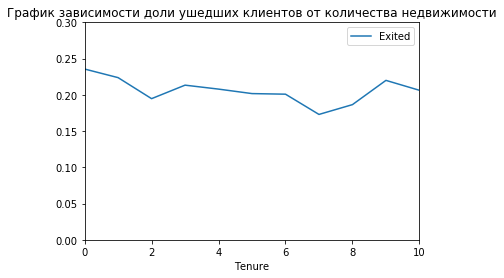

In [3]:
tenure = pd.pivot_table(data, index='Tenure', values='Exited')
tenure.plot(title='График зависимости доли ушедших клиентов от количества недвижимости')
plt.ylim(0, 0.3)
tenure

Из графика видно, что количество недвижимости ощутимо не влияет на вероятность ухода клиента из банка, поэтому не будем включать этот признак в нашу модель. Таким образом избавимся от проблемы с большим количеством пропусков.

Столбцы **RowNumber**, **CustomerId**, **Surname** не несут полезной информации для расчёта модели. Также избавимся от них.

In [4]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Tenure'], axis=1)

В столбцах **Geography** и **Gender** содержатся категариальые  переменные, преобразуем их с помощью техники One-Hot Encoding.

In [5]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделим данные на три выборки: обучающая (60%), валидационная (20%) и тренировочная (20%)

In [6]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

features_train, features_valtest, target_train, target_valtest = train_test_split(
    features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valtest, target_valtest, test_size=0.5, random_state=42)

Для построения более адекватной модели необходимо провести масштабирование признаков. Стандартизируем все признаки кроме бинарных.

In [7]:
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

scaled_train = features_train.copy()
scaled_valid = features_valid.copy()
scaled_test = features_test.copy()

scaled_train[numeric] = scaler.transform(features_train[numeric])
scaled_valid[numeric] = scaler.transform(features_valid[numeric])
scaled_test[numeric] = scaler.transform(features_test[numeric])
scaled_train[numeric]

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
9761,1.603068,2.027653,-0.048229,0.824078,-1.452982
3159,1.883194,-1.520072,0.884122,-0.905967,-1.403696
1489,-0.451185,0.014079,1.050751,-0.905967,1.290549
2987,0.243941,-1.232419,0.517839,-0.905967,-0.709924
812,-1.416062,-0.561228,-1.214721,0.824078,-0.736719
...,...,...,...,...,...
5734,1.198443,1.452346,-0.099972,-0.905967,-0.551364
5191,0.306191,1.835884,-1.214721,-0.905967,-1.741511
5390,0.856067,-0.081805,-1.214721,2.554124,-0.155558
860,0.150566,0.397617,1.827130,-0.905967,-0.063917


# 2. Исследование задачи

##### Баланс классов

0    0.7963
1    0.2037
Name: Exited, dtype: float64

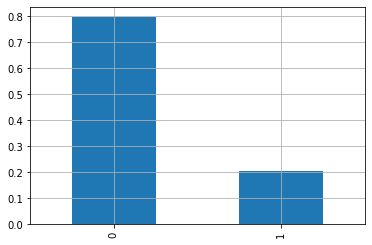

In [8]:
target.value_counts(normalize=True).plot(kind='bar', grid=True)
target.value_counts(normalize=True)

Наблюдается явный дисбаланс: ушедших клиентов почти в 4 раза меньше оставшихся.  Это не лучшим образом влияет на качество моделей.  
Но сперва построим модели без баланса классов.

##### Дерево решений

Посчитаем F1-меру и долю правильных ответов при разной высоте дерева

    f1_train  f1_valid accuracy_valid   auc_roc
2   0.510246  0.474916          0.843  0.708465
3   0.536217  0.500818         0.8475  0.770968
4   0.512707  0.471869         0.8545  0.786643
5   0.578422  0.508091          0.848  0.798223
6   0.611858  0.527687          0.855  0.807386
7   0.645545  0.510851         0.8535  0.804222
8   0.682163  0.523364          0.847  0.806192
9   0.712071  0.526636         0.8445   0.78378
10  0.751838  0.512518         0.8345  0.763283
11  0.787033  0.500715         0.8255  0.713605
12  0.833406  0.474341         0.8105  0.688226
13  0.863297  0.481013         0.8155  0.685159
14  0.901408  0.473896         0.8035  0.688979
15  0.927035  0.457766          0.801   0.67961
16  0.950021   0.45839         0.8015  0.682754
17  0.970906  0.457293         0.7935  0.678427
18  0.982716  0.461538         0.7935  0.676152
19  0.991803  0.455863         0.7935   0.66887
20  0.994674  0.453956         0.7895  0.666317
21  0.995497  0.453125           0.79  0

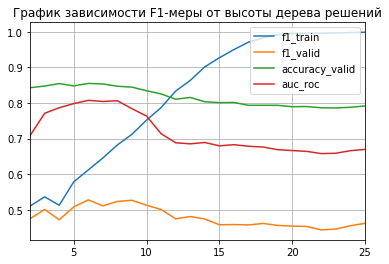

In [9]:
columns = ['f1_train', 'f1_valid', 'accuracy_valid', 'auc_roc']
f1_tree = pd.DataFrame(columns=columns)
for depth in range(2, 26):
    model = DecisionTreeClassifier(random_state=2020, max_depth=depth)
    model.fit(scaled_train, target_train)
    probabilities = model.predict_proba(scaled_valid)
    probabilities_one = probabilities[:, 1]
    predicted_train = model.predict(scaled_train)
    predicted_valid = model.predict(scaled_valid)
    f1_tree.loc[depth, 'f1_train'] = f1_score(target_train, predicted_train)
    f1_tree.loc[depth, 'f1_valid'] = f1_score(target_valid, predicted_valid)
    f1_tree.loc[depth, 'accuracy_valid'] = model.score(scaled_valid, target_valid)
    f1_tree.loc[depth, 'auc_roc'] = roc_auc_score(target_valid, probabilities_one)
    
print(f1_tree)
f1_tree.plot(grid=True, title='График зависимости F1-меры от высоты дерева решений');

Наилучший результат получился при *max_depth*=6 (AUC-ROC также наибольший получился). Картина ожидаемо получилась аналогичной подобному графику для метрики *accuracy* из прошлого проекта: при увеличении высота дерева F1-мера растёт до единицы для тренирвочной выборки, а для валидационной сначала растёт до некоторого уровня и затем снижается.

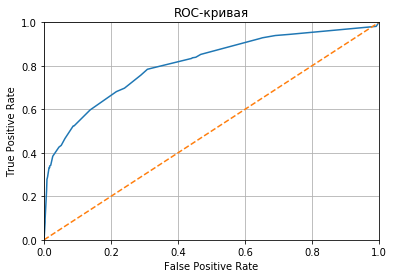

Доля верных ответов = 0.855
Точность = 0.692
Полнота = 0.426
F1-мера = 0.528
AUC-ROC = 0.807


In [10]:
def print_metrics(model, features_data, target_data):
    predicted_data = model.predict(features_data)
    probabilities = model.predict_proba(features_data)
    probabilities_one = probabilities[:, 1]

    fpr, tpr, thresholds = roc_curve(target_data, probabilities_one)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
    print('Доля верных ответов = {:.3f}'.format(model.score(features_data, target_data)))
    print('Точность = {:.3f}'.format(precision_score(target_data, predicted_data)))
    print('Полнота = {:.3f}'.format(recall_score(target_data, predicted_data)))
    print('F1-мера = {:.3f}'.format(f1_score(target_data, predicted_data)))
    print('AUC-ROC = {:.3f}'.format(roc_auc_score(target_data, probabilities_one)))
    
model_dtc = DecisionTreeClassifier(random_state=42, max_depth=6)
model_dtc.fit(scaled_train, target_train)
print_metrics(model_dtc, scaled_valid, target_valid)

##### Случайный лес

Для поиска подходящих гиперпараметров воспользуемся методом Grid Search

In [11]:
model = RandomForestClassifier(random_state=42)

grid_param = {'n_estimators' : [50 * x for x in range(1, 7)],
              'max_depth' : [5 * x for x in range(1, 11)]}

grid_search = GridSearchCV(model, grid_param, scoring='f1', n_jobs=-1, cv=3)
grid_search.fit(scaled_train, target_train)
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 150}

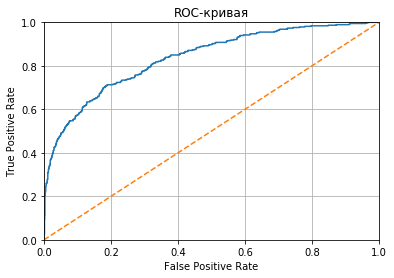

Доля верных ответов = 0.866
Точность = 0.741
Полнота = 0.453
F1-мера = 0.562
AUC-ROC = 0.837


In [12]:
model_rfc = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=15)
model_rfc.fit(scaled_train, target_train)
print_metrics(model_rfc, scaled_valid, target_valid)

##### Логистическая регрессия 

In [13]:
model = LogisticRegression(random_state=42)
grid_param = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(model, grid_param, scoring='f1', cv=3)
grid_search.fit(scaled_train, target_train)
grid_search.best_params_

{'solver': 'liblinear'}

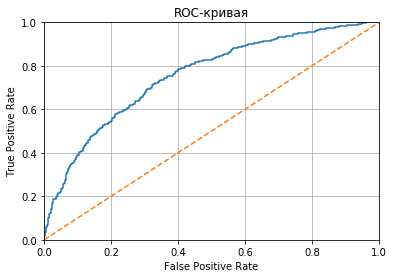

Доля верных ответов = 0.817
Точность = 0.550
Полнота = 0.203
F1-мера = 0.296
AUC-ROC = 0.754


In [14]:
model_lr = LogisticRegression(random_state=42, solver='liblinear')
model_lr.fit(scaled_train, target_train)
print_metrics(model_lr, scaled_valid, target_valid)

+ Все модели по метрике accuracy оказались лучше константной модели (у неё примерно 0.79).
+ Лучшая модель - случайный лес (F1 = 0.562), худшая - логистическая регрессия (F1 = 0.299).
+ F1-мера - агрегирующая метрика, максимизация которой даёт оптимальное соотношение точности и полноты.
+ Для исследованных моделей более высокая F1-мера сопровождалась более высокой AUC-ROC.

# 3. Борьба с дисбалансом

Как уже было отмечено, у нас есть дисбаланс классов, попробуем решить проблему разными способами. В каждом новом случае повторно будем использовать Grid search для подбора гиперпараметров.  

**Примечание:** Далее будет рассматриваться только модель случайного леса, как показавшая наилучший результат. Интереса ради я посмотрел логистическую регрессию и дерево решений (достичь нужной величины F1-меры не получилось), но чтобы не перегружать ноутбук не стал приводить все выкладки.

##### Взвешивание классов

Используем параметр модели *class_weight*, который увеличит вес положительного класса.

In [15]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_param = {'n_estimators' : [50 * x for x in range(1, 7)],
              'max_depth' : [5 * x for x in range(1, 11)]}

grid_search = GridSearchCV(model, grid_param, scoring='f1', n_jobs=-1, cv=3)
grid_search.fit(scaled_train, target_train)
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 300}

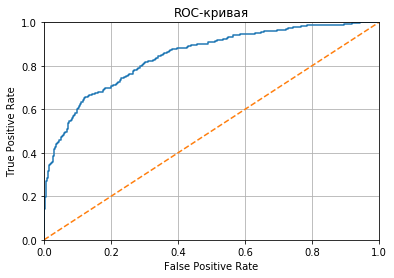

Доля верных ответов = 0.843
Точность = 0.582
Полнота = 0.605
F1-мера = 0.594
AUC-ROC = 0.846


In [20]:
model_rfc_b = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=10, class_weight='balanced')
model_rfc_b.fit(scaled_train, target_train)
print_metrics(model_rfc_b, scaled_valid, target_valid)

Взвешивание классов дало прирост F1-меры на 0.033. Эффективность взвешивания классов налицо.

##### Upsampling

Техника upsampling позволяет увеличить количество объектов редкого класса путём их кратного копирования:  

+ Разделяем обучающую выборку на отрицательные и положительные объекты;
+ Копируем несколько раз положительные объекты;
+ С учётом полученных данных создаём новую обучающую выборку;
+ Перемешиваем данные.

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [42]:
def score_model(model, params, cv, technique, n):
    scores = []
    
    # Цикл для перебора тренировочных и валидационных подвыборок
    for train_fold_index, val_fold_index in cv.split(scaled_train, target_train):
        
        # Выбираем тренировочные данные
        X_train_fold, y_train_fold = scaled_train.iloc[train_fold_index], target_train.iloc[train_fold_index]
        
        # Выбираем валидационные данные
        X_val_fold, y_val_fold = scaled_train.iloc[val_fold_index], target_train.iloc[val_fold_index]
        
        # Делаем upsampling или downsampling
        if technique == 'upsampling':
            X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_fold, y_train_fold, n)
        elif technique == 'downsampling':
            X_train_fold_upsample, y_train_fold_upsample = downsample(X_train_fold, y_train_fold, n)
       
        # Обучаем модель на тренировочных данных    
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        
        # Определяем целевую метрику и записываем в массив
        score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [43]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
grid_param = {'n_estimators' : [50 * x for x in range(3, 12)],
              'max_depth' : [5 * x for x in range(1, 6)]}

# Цикл для перебора гиперпараметров
score_tracker = []
for n_estimators in grid_param['n_estimators']:
    for max_depth in grid_param['max_depth']:
        params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 42
        }
        # Считаем среднее значение метрики для каждого набора гиперпараметров и записываем в список
        params['f1'] = score_model(RandomForestClassifier, params, cv=kf, technique='upsampling', n=4).mean()
        score_tracker.append(params)

In [44]:
# Выбираем гиперпараметры с наибольшим значением метрики
sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]

{'n_estimators': 500,
 'max_depth': 10,
 'random_state': 42,
 'f1': 0.6158841488173271}

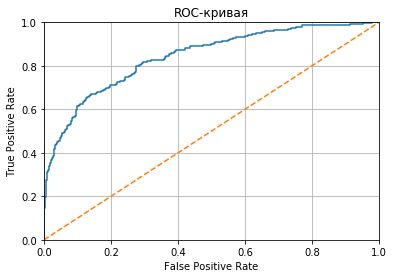

Доля верных ответов = 0.825
Точность = 0.532
Полнота = 0.666
F1-мера = 0.591
AUC-ROC = 0.842


In [45]:
features_upsampled, target_upsampled = upsample(scaled_train, target_train, 4)

model_rfc_u = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=10)
model_rfc_u.fit(features_upsampled, target_upsampled)
print_metrics(model_rfc_u, scaled_valid, target_valid)

Здесь результат незначительно хуже, чем со взвешиванием классов. Думаю это вызвано случайными факторами и в нашем случае можно считать эффективность upsemling'а и взвешивания классов одинаковой.

##### Downsampling

Техника downsampling аналогична технике upsamplig, с той лишь разницей, что мы уменьшаем отрицательный класс.

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [47]:
grid_param = {'n_estimators' : [50 * x for x in range(3, 12)],
              'max_depth' : [5 * x for x in range(1, 6)]}

score_tracker = []
for n_estimators in grid_param['n_estimators']:
    for max_depth in grid_param['max_depth']:
        params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 42
        }
        params['f1'] = score_model(RandomForestClassifier, params, cv=kf, technique='downsampling', n=0.25).mean()
        score_tracker.append(params)

In [48]:
sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]

{'n_estimators': 350,
 'max_depth': 10,
 'random_state': 42,
 'f1': 0.5855237082608933}

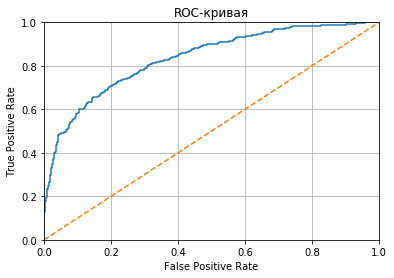

Доля верных ответов = 0.770
Точность = 0.437
Полнота = 0.726
F1-мера = 0.545
AUC-ROC = 0.835


In [49]:
features_downsampled, target_downsampled = downsample(scaled_train, target_train, 0.25)

model_rfc_d = RandomForestClassifier(random_state=42, n_estimators=350, max_depth=10)
model_rfc_d.fit(features_downsampled, target_downsampled)
print_metrics(model_rfc_d, scaled_valid, target_valid)

+ Техника downsampling'а привела к ухудшению результата. Из-за "недообучения" на отрицательном классе она стала чаще давать ложноположительные ответы, об этом свидетельствует высокая полнота и низкая точность.  
+ Здесь мы получили довольно высокую полноту, что конкретно в нашей задаче для предотвращения оттока клиентов, пожалуй, более предпочтительное поведение модели.
+ Что примечательно, метрика AUC-ROC здесь выше (0.835), чем в примере с upsampling'ом (0.826). Отсюда могу сделать вывод, что метрика AUC-ROC так сказать генерализованная метрика отражающая качество модели в целом и её максимизация может не приводить к требуемым результатам.

# 4. Тестирование модели

Лучшей моделью оказался Случайный лес со взвешиванием классов, тестирование проведём на нём. Перед финальным тестированием объединим обучающую и валидационную выборки, чтобы предоставить модели больше данных.

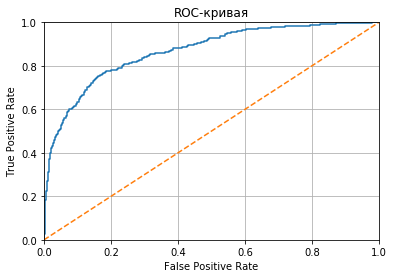

Доля верных ответов = 0.841
Точность = 0.625
Полнота = 0.644
F1-мера = 0.635
AUC-ROC = 0.867


In [50]:
features_train_full = scaled_train.append(scaled_valid)
target_train_full = target_train.append(target_valid)

model_final = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=10, class_weight='balanced')
model_final.fit(features_train_full, target_train_full)

print_metrics(model_final, scaled_test, target_test)

+ Предобработка данных и устранение дисбаланса классов привело к значительному улучшение модели
+ Лучшие результыт показывает наиболее ресурсозатратная модель Случайного леса.
+ F1-мера > 0.59. Задача выполнена.